In [1]:
from datasets import load_dataset
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from PIL import Image
import torch
import pandas as pd
import numpy as np

from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig

import torch
import numpy as np
import random
import io

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import colorsys
import pickle
from collections import defaultdict

# Set a specific seed for reproducibility
SEED = 42

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

# Set seed for other libraries if necessary
np.random.seed(SEED)
random.seed(SEED)

base_path = "[ENTER YOUR FILE PATH TO THE DOWNLOADED IMAGES]"
df = pd.read_csv("final_images_with_counterfact.csv")

In [2]:
# This is for all colors EXCEPT for White. 
def color_remap(pixel, current_color, target_color, alpha=0.2, saturation_threshold=0.1):
    """Remaps pixels from current_color to target_color within a hue range."""    


    color_hue_map = {
        "red": 0.0,         
        "brown": 0.05,
        "pink": 0.9,        
        "orange": 0.07,     
        "yellow": 0.15,
        "gold": 0.1,
        "green": 0.33,              
        "blue": 0.55,      
        "purple": 0.78,     
        "black": 0.0,     
        "grey": 0.0,
        "silver": 0.0,
        "white": 0.0,     
    }
        
    current_hue = color_hue_map[current_color]    
    target_hue = color_hue_map[target_color]
    
    r, g, b = pixel
    h, s, v = colorsys.rgb_to_hsv(r / 255.0, g / 255.0, b / 255.0)  

    if current_color in ['black', 'grey', 'silver']:
        if v < 0.75 and s < 0.5:
            new_h = target_hue
    
            # Custom logic per target color
            if target_color == 'red':
                new_h = target_hue  # around 0.0
                new_s = max(0.4, min(1.0, s * 1.5 + 0.35))
                new_v = max(0.4, min(1.0, v * 2 + 0.25))
    
            elif target_color == 'brown':
                new_h = target_hue  # around 0.05 - 0.08
                new_s = max(0.7, min(0.9, s + 0.3))
                new_v = max(0.3, min(0.5, v + 0.2))  # darker
    
            elif target_color == 'pink':
                new_h = target_hue  # around 0.9 - 1.0
                # Lower the brightness boost so pinks are less light.
                new_v = max(0.80, min(1.0, v * 1.750 + 0.2))
                # Adjust saturation gently to keep a soft pink without over-saturating.
                new_s = max(0.4, min(0.7, s * 1.5 + 0.2))
    
            elif target_color == 'orange':
                new_h = target_hue
    
                # Boost saturation aggressively into the vivid region.
                # Using a multiplier and an offset to ensure a high saturation.
                new_s = max(0.90, min(1.0, s * 2.2 + 0.35))
    
                # Increase brightness to be vivid without overexposing,
                # ensuring the pixel leaves the 'black' territory.
                new_v = max(0.85, min(1.0, v * 2.2 + 0.35))
    
            elif target_color == 'yellow':
                new_h = target_hue  # around 0.13 - 0.17
                new_s = max(0.6, min(1.0, s * 1.6 + 0.2))
                new_v = max(0.7, min(1.0, v * 1.65 + 0.3))  # very bright
    
            elif target_color == 'green':
                new_h = target_hue  # around 0.25 - 0.4
                new_s = max(0.65, min(1.0, s * 1.8 + 0.3))
                new_v = max(0.55, min(1.0, v * 1.6 + 0.3))
    
            elif target_color == 'blue':
                new_h = target_hue  # around 0.55 - 0.65
                new_s = max(0.8, min(1.0, s * 2 + 0.4))
                new_v = max(0.7, min(1.0, v * 1.5 + 0.2))
    
            elif target_color == 'purple':
                new_h = target_hue  # around 0.75 - 0.85
                new_s = max(0.65, min(1.0, s * 1.6 + 0.25))
                new_v = max(0.55, min(1.0, v * 1.5 + 0.35))
    
            else:
                # Default fallback
                new_s = min((s + 0.3) * 1.5, 1)
                new_v = min((v + 0.3) * 1.5, 1)
    
            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)

    elif current_color == 'brown':
        if (0.0 <= h <= 0.15 and 0.25 <= s <= 1 and 0 <= v <= 0.95):
            new_h = target_hue
            if v < 0.6 and s < 0.8:
                new_v = min((v+0.05)*1.1, 1)
                new_s = min((s+0.1)*1.1, 1)
            else:
                new_v = min(v, 1)
                new_s = min(s, 1)
                
            if target_color == 'grey':
                # This gives gray
                new_h = 0
                new_s = 0
                new_v = v*0.75
                
            if target_color == 'orange':
                new_v = min(v*1.75, 1)
                new_s = min(s*1.75, 1)
            
            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)
            
    elif current_color == 'white':
        if s <= 0.1 and v >= 0.5:
            new_h = target_hue
            new_v = v*0.95
            new_s = min((s+0.2)*1.75, 1)

            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)
        
    # ADD LOGIC FOR RED
    elif current_color == 'red':
        if ((h < 0.1 or h > 0.9) and s >= 0.2 and v >= 0.2):
            new_h = target_hue
            new_v = v
            new_s = s*0.95
            
            if target_color == 'black':
                # This gives gray
                r, g, b = colorsys.hsv_to_rgb(h, 0, v*0.35)
                return int(r * 255), int(g * 255), int(b * 255)
            
            if target_color == 'grey':
                # This gives gray
                r, g, b = colorsys.hsv_to_rgb(0, 0, v*0.75)
                return int(r * 255), int(g * 255), int(b * 255)
            
            if target_color == 'brown':
                new_h = target_hue
                new_v = v*0.65          
                new_s = s*0.85
                r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
                return int(r * 255), int(g * 255), int(b * 255)


            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)

    if current_color == "pink":
        # This condition now covers pink and slightly orange-leaning pixels.
        if ((h <= 0.16 or h >= 0.85) and 0.05 <= s <= 0.9 and v >= 0.6):
            new_h = target_hue  # remap the hue to your target color
    
            # If the hue falls in the orange-leaning range, apply a slightly stronger boost,
            # otherwise use a gentle boost for classic pinks.
            if 0.06 <= h <= 0.16:
                new_s = min(max(s * 1.25 + 0.1, 0.5), 1.0)
                new_v = min(v + 0.1, 1.0)
            else:
                new_s = min(max(s * 1.2 + 0.1, 0.4), 1.0)
                new_v = min(v + 0.05, 1.0)
    
            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)         
    else:
        # Check if the hue is in range and the saturation is above threshold
        # hue is the base color
        # saturation threshold is needed to we don't color the background! 
        if abs(h - current_hue) < alpha and s > saturation_threshold:
            
            if target_color == 'black':
                # This gives gray
                r, g, b = colorsys.hsv_to_rgb(h, 0, v*0.35)
                return int(r * 255), int(g * 255), int(b * 255)
            
            if target_color == 'grey':
                # This gives gray
                r, g, b = colorsys.hsv_to_rgb(0, 0, v*0.75)
                return int(r * 255), int(g * 255), int(b * 255)
            
            if target_color == 'brown':
                new_h = target_hue
                new_v = v*0.65          
                new_s = s*0.75
                r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
                return int(r * 255), int(g * 255), int(b * 255)


            new_h = target_hue  
            new_v = min(v, 0.95)  #brightness boost
            new_s = min(s*1.1, 1)     #saturation boost

            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)

    return pixel

118
Original Color: red. New Color: blue
downloaded_images/red_cherry_1.jpg


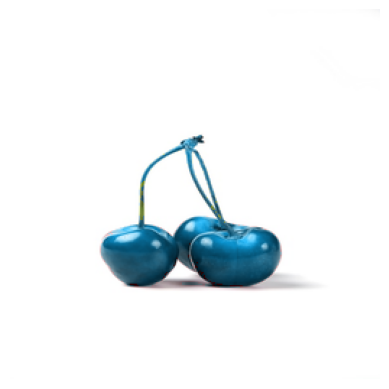

images/red
245
Original Color: green. New Color: purple
downloaded_images/green_budgie_1.jpg


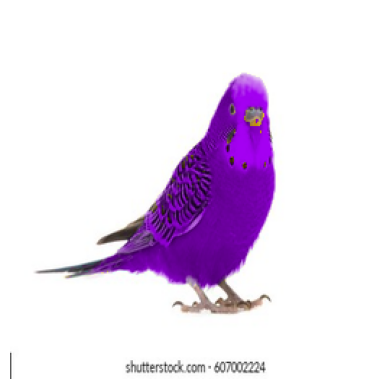

images/green
278
Original Color: blue. New Color: brown
downloaded_images/blue_container_ship_2.jpg


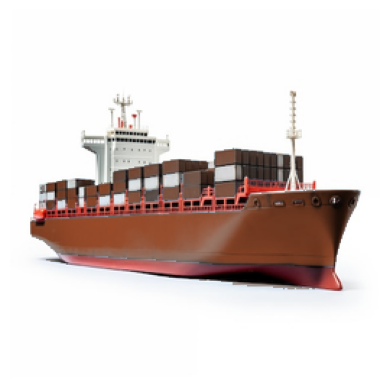

images/blue
234
Original Color: black. New Color: pink
downloaded_images/black_black_stork_1.jpg


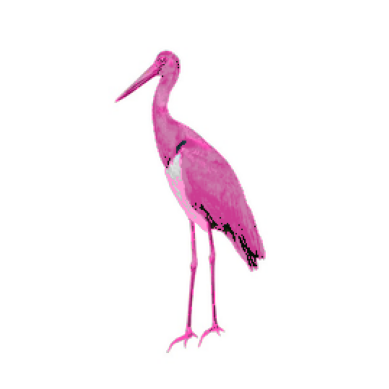

images/black
29
Original Color: brown. New Color: purple
downloaded_images/brown_beaver_1.jpg


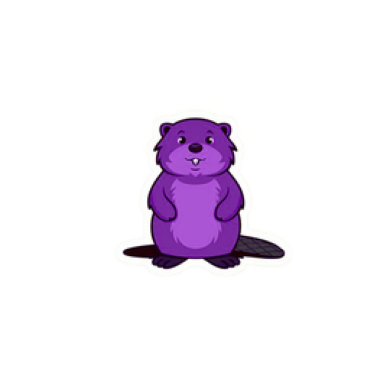

images/brown
82
Original Color: green. New Color: pink
downloaded_images/green_lettuce_1.jpg


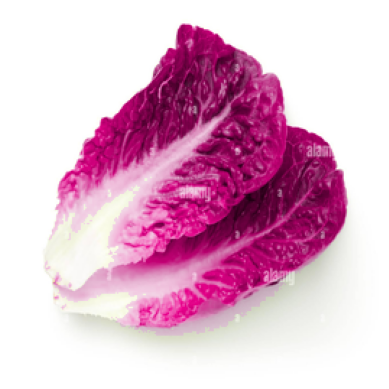

images/green
158
Original Color: yellow. New Color: blue
downloaded_images/yellow_banana_2.jpg


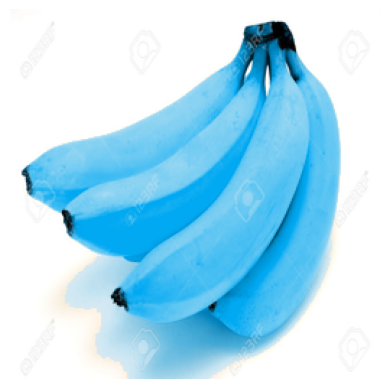

images/yellow


In [4]:
counterfact_paths = {}
# REMOVE SAMPLE TO RUN ON FULL DATASET
for idx, row in df.sample(10).iterrows():
    
    if row['correct_answer'] == 'white':
        continue 
    
    else:
        print(idx)
        print(f"Original Color: {row['correct_answer']}. New Color: {row['incorrect_answer']}")
        print(row["image_path"])
        img = Image.open(base_path + row["image_path"]).convert("RGB").resize((256, 256), Image.LANCZOS)

        # Get the data from the image
        pixels = list(img.getdata())

        # Map over the pixels using the green_to_orange function
        remapped_pixels = [color_remap(pixel, row['correct_answer'], row['incorrect_answer'].lower()) for pixel in pixels]

        # Create a new image from the remapped pixels
        img_remapped = Image.new('RGB', img.size)
        img_remapped.putdata(remapped_pixels)
        
        plt.imshow(img_remapped)
        plt.axis("off")  # Hide axes
        plt.show()
        
        color_to_replace = row['image_path'].split('_')[1]
        print(color_to_replace)
        
        new_path = row['image_path'].replace(color_to_replace, row['incorrect_answer'])
        new_path = new_path.replace('downloaded_images', 'downloaded_images_counterfact')
        counterfact_paths[idx] = new_path

        img_remapped.save(new_path)

# Generating Segmentation Masks with SAM 

## SAM

In [5]:
#from datasets import load_dataset
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from PIL import Image
import torch
import pandas as pd
import numpy as np

from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig

import torch
import numpy as np
import random
import io

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import colorsys
#import pickle
#from collections import defaultdict

# Set a specific seed for reproducibility
SEED = 42

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

# Set seed for other libraries if necessary
np.random.seed(SEED)
random.seed(SEED)

base_path = "/users/wrudman/data/multimodal_MI/visual_counterfact/"
df = pd.read_csv("final_images_with_counterfact.csv")

#base_path = "/users/wrudman/data/visual_counterfact/color_images/"
#df = pd.read_csv("../vlm_counterfact_color.csv")

In [6]:
#IMPORTANT. You cannot use run this code in the parent directory that sam2 was cloned into. 
# you can either go to a different directory, or go into sam2 itself. 
import os
os.chdir("sam2")

In [7]:
# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.float16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [8]:
def show_points(coords, labels, ax, marker_size=375):
    """Sam2 function to show points."""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    """Sam2 function to show the box over the image."""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    



def show_mask(mask, ax, random_color=False, borders = True):
    """Visualize mask in the image"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)
    
def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    """Plot ALL images masks in a set"""
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [9]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Sam model path.
sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

/usr/bin/xdg-open: line 881: www-browser: command not found
/usr/bin/xdg-open: line 881: links2: command not found
/usr/bin/xdg-open: line 881: elinks: command not found
/usr/bin/xdg-open: line 881: links: command not found


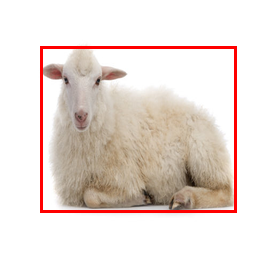

/usr/bin/xdg-open: line 881: lynx: command not found
/usr/bin/xdg-open: line 881: w3m: command not found
xdg-open: no method available for opening '/tmp/tmppi8fihgb.PNG'


In [11]:
from PIL import Image, ImageDraw

def find_bounding_box(image, saturation_threshold=0.1):
    """Finds the bounding box around the object with colors in the image."""
    image = image.convert("RGB")
    pixels = image.load()
    width, height = image.size

    min_x, min_y = width, height
    max_x, max_y = 0, 0

    for y in range(height):
        for x in range(width):
            r, g, b = pixels[x, y]
            h, s, v = colorsys.rgb_to_hsv(r / 255.0, g / 255.0, b / 255.0)

            if s > saturation_threshold or v < 0.5:  # Exclude white background
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x)
                max_y = max(max_y, y)

    if min_x > max_x or min_y > max_y:
        min_x, min_y = 0, 0
        max_x, max_y = width - 1, height - 1

    return (min_x, min_y, max_x, max_y)

import numpy as np
from PIL import Image, ImageFilter
import cv2

def find_bounding_box_with_edges(image: Image.Image):
    """Bounding fox for white objects"""
    image = image.convert("L")  # Convert to grayscale
    blurred = image.filter(ImageFilter.GaussianBlur(2))  # Reduce noise
    np_img = np.array(blurred)

    # Edge detection (Canny)
    edges = cv2.Canny(np_img, threshold1=30, threshold2=100)

    # Find contours from edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return (0, 0, image.width - 1, image.height - 1)

    # Get the bounding box that encompasses all contours
    x, y, w, h = cv2.boundingRect(np.vstack(contours))
    return (x, y, x + w, y + h)

def draw_bounding_box(image, bbox, color="red", thickness=3):
    """Draws a bounding box on the image."""
    if bbox is None:
        return image  # No bounding box found

    draw = ImageDraw.Draw(image)
    min_x, min_y, max_x, max_y = bbox

    for i in range(thickness):
        draw.rectangle([min_x - i, min_y - i, max_x + i, max_y + i], outline=color)

    return image


row = df.iloc[154]

img = Image.open(base_path + row["image_path"]).convert("RGB").resize((256, 256), Image.LANCZOS)

bbox = find_bounding_box(img)
image_with_bbox = draw_bounding_box(img, bbox)
image_with_bbox.show()  # Display the image
image_with_bbox

predictor.set_image(img)

img

In [12]:
import numpy as np

def fix_inverse_mask(mask, edge_threshold=0.05, center_fraction=0.5):
    """
    Detects if a SAM-generated mask is inverted and corrects it if necessary.
    
    Args:
        mask (np.array): A 256x256 binary mask.
        edge_threshold (float): The fraction of the image width/height to consider as an edge.
        center_fraction (float): The fraction of the image width/height to consider as the central region.
        
    Returns:
        np.array: The corrected mask.
    """
    mask = mask[0]
    height, width = mask.shape
    
    # Define center region
    center_x_min = int((1 - center_fraction) / 2 * width)
    center_x_max = int((1 + center_fraction) / 2 * width)
    center_y_min = int((1 - center_fraction) / 2 * height)
    center_y_max = int((1 + center_fraction) / 2 * height)

    center_region = mask[center_y_min:center_y_max, center_x_min:center_x_max]
    
    # Count object and background pixels in the center
    object_count = np.sum(center_region == 1)
    background_count = np.sum(center_region == 0)

    # Define edge regions
    edge_size = int(edge_threshold * width)
    
    top_edge = mask[:edge_size, :]
    bottom_edge = mask[-edge_size:, :]
    left_edge = mask[:, :edge_size]
    right_edge = mask[:, -edge_size:]
    
    edges = np.concatenate([top_edge.flatten(), bottom_edge.flatten(), left_edge.flatten(), right_edge.flatten()])
    
    # Count object and background pixels in the edges
    edge_object_count = np.sum(edges == 1)
    edge_background_count = np.sum(edges == 0)

    # If the center is mostly background (0) and edges are mostly object (1), it's likely inverted
    if background_count > object_count and edge_object_count > edge_background_count:
        return np.expand_dims(1-mask, axis=0)  # Invert the mask

    return np.expand_dims(mask, axis=0)  # Return as is if not inverted


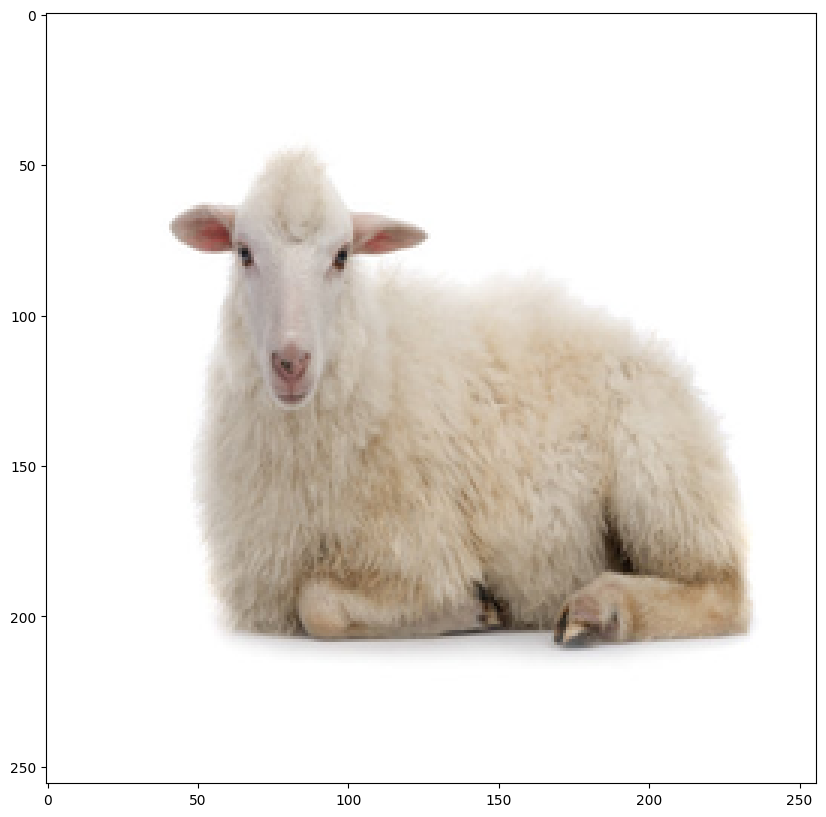

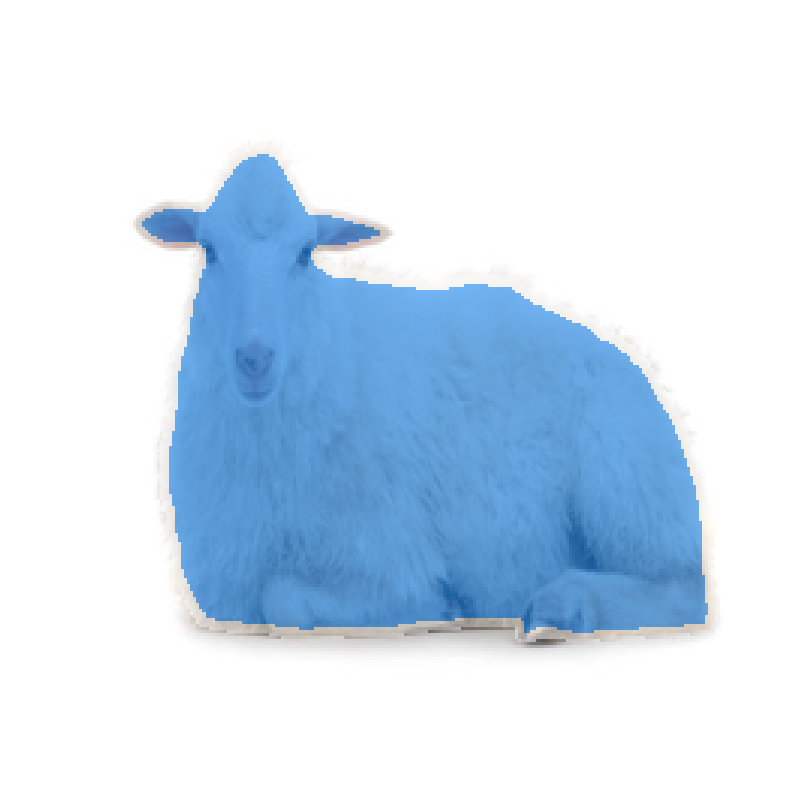

In [13]:
import matplotlib.pyplot as plt

row = df.iloc[154]
img = Image.open(base_path + row["image_path"]).convert("RGB").resize((256, 256), Image.LANCZOS)


predictor.set_image(img)


plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('on')
plt.show()  

masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=np.array(bbox)[None, :],
    multimask_output=False,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

masks = fix_inverse_mask(masks)
#print(masks.shape)

show_masks(img, masks, scores, borders=True)

## Getting Masks for Non-White Objects

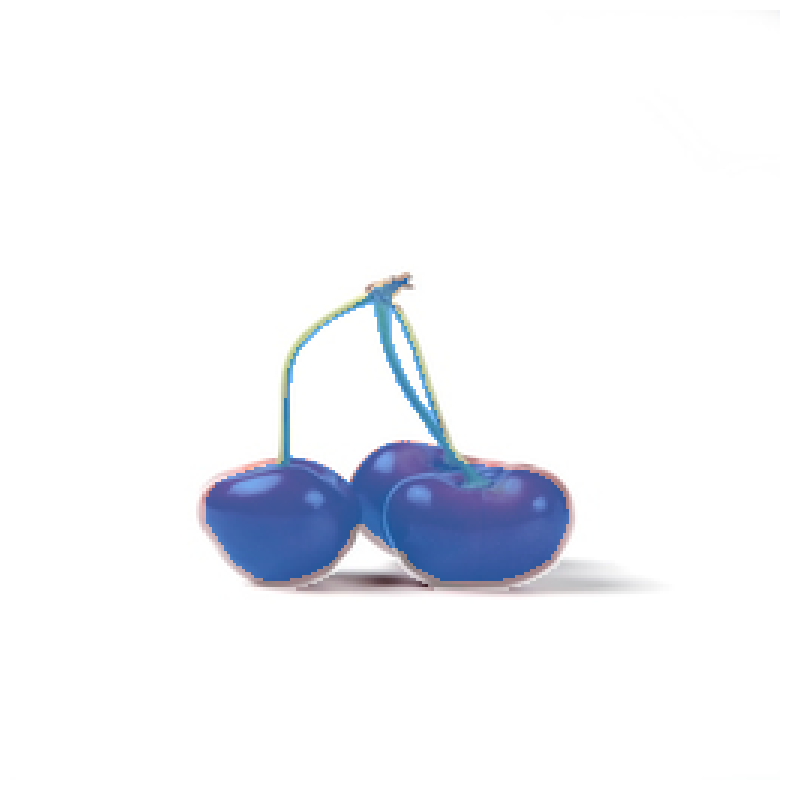

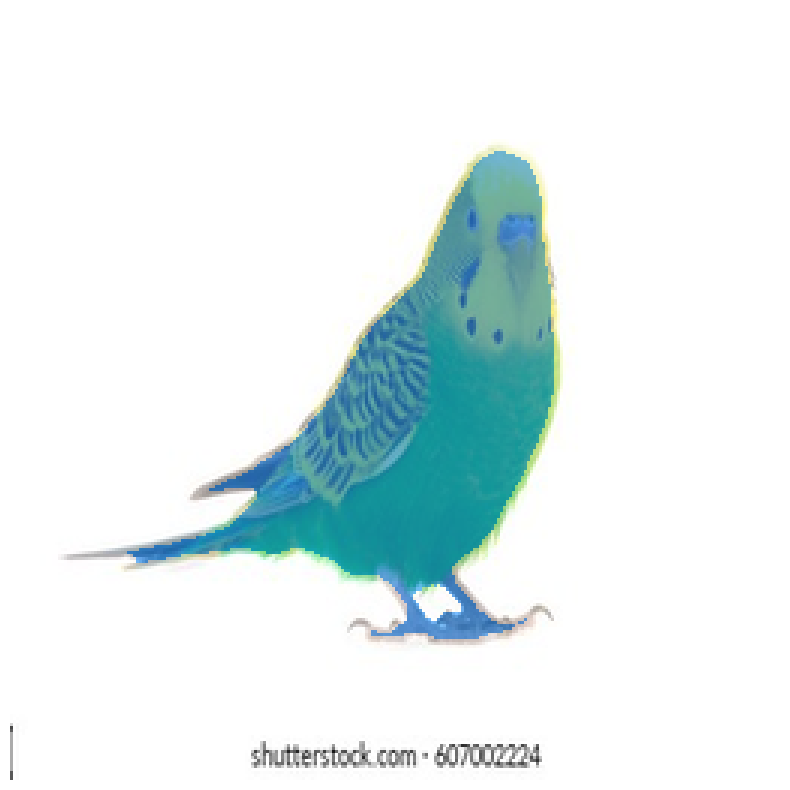

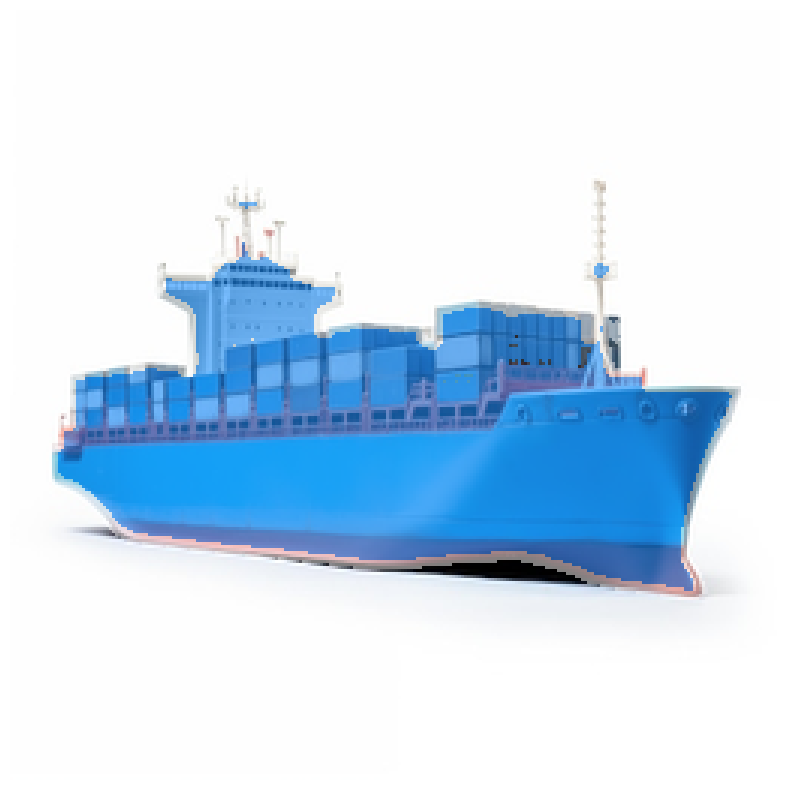

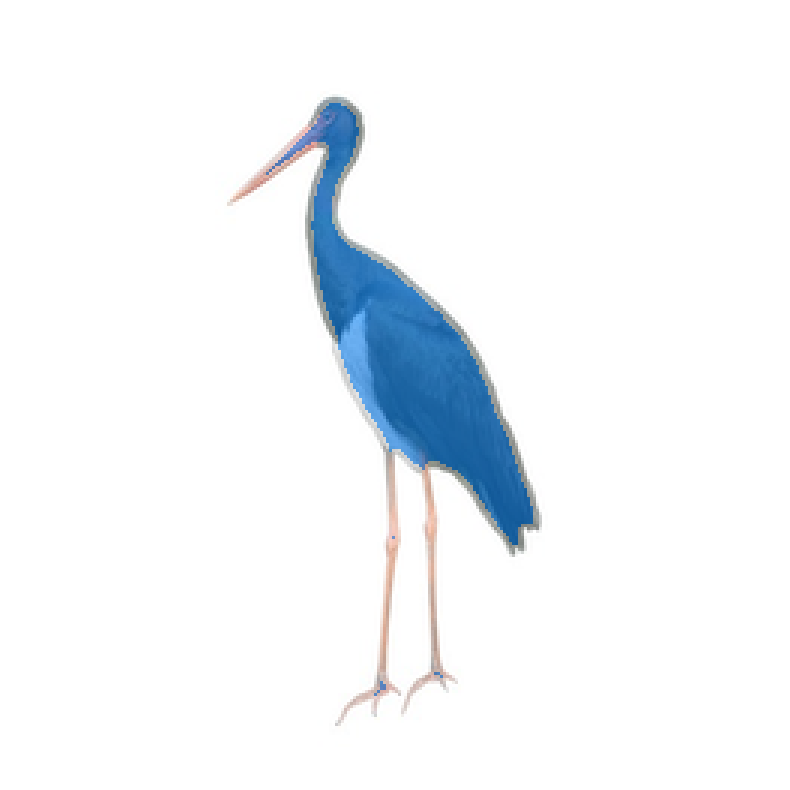

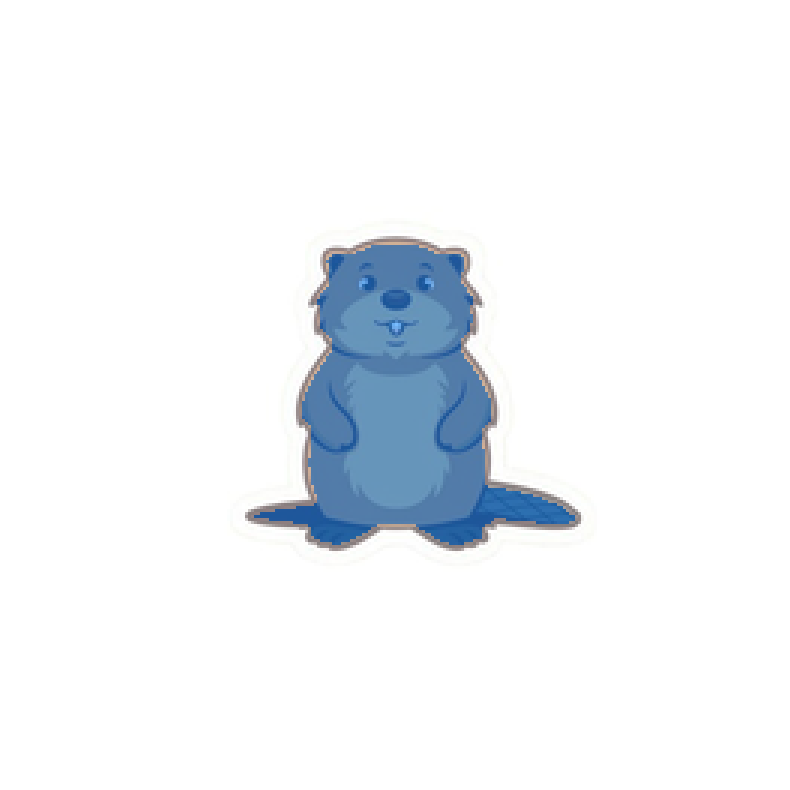

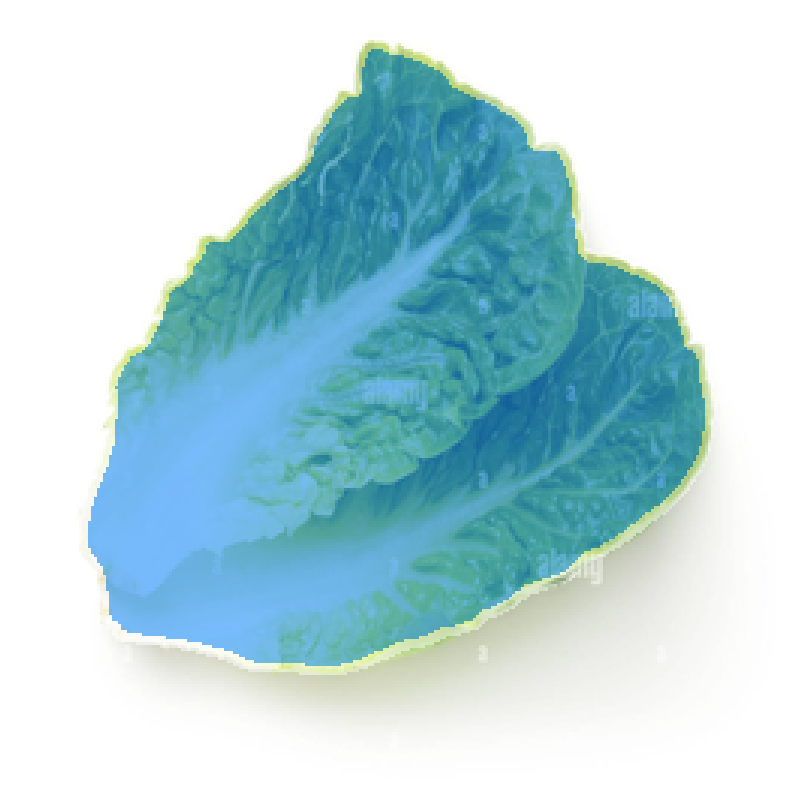

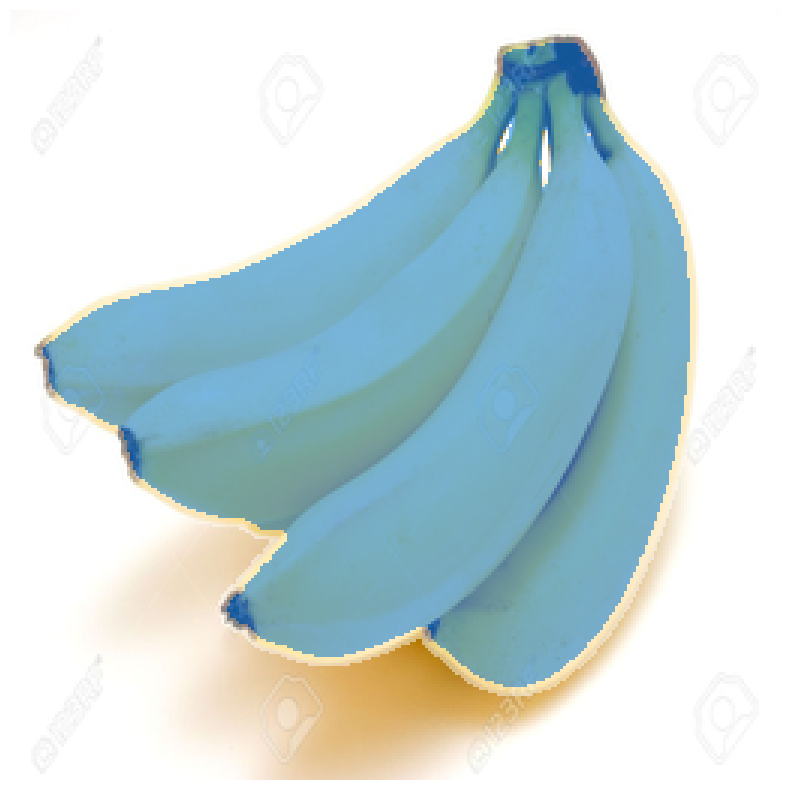

In [14]:
import pickle
all_masks = {}

for idx, row in df.sample(10).iterrows():
# UNCOMMENT to run for the full datset.
#for idx, row in df.iterrows():
    if row['correct_answer'] == 'white':
        continue 
    
    img = Image.open(base_path + row["image_path"]).convert("RGB").resize((256, 256), Image.LANCZOS)
    bbox = find_bounding_box(img)
    predictor.set_image(img)

    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=np.array(bbox)[None, :],
        multimask_output=False,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]

    masks = fix_inverse_mask(masks)
    show_masks(img, masks, scores, borders=True)
    
    all_masks[counterfact_paths[idx]] = masks[0]
   
with open("final_real_images_masks_color.pkl", "wb") as f:
    pickle.dump(all_masks, f)


## Generating Masks for White Objects & Color Re-Mapping White Objects

Processing: downloaded_images/white_sink_2.jpg


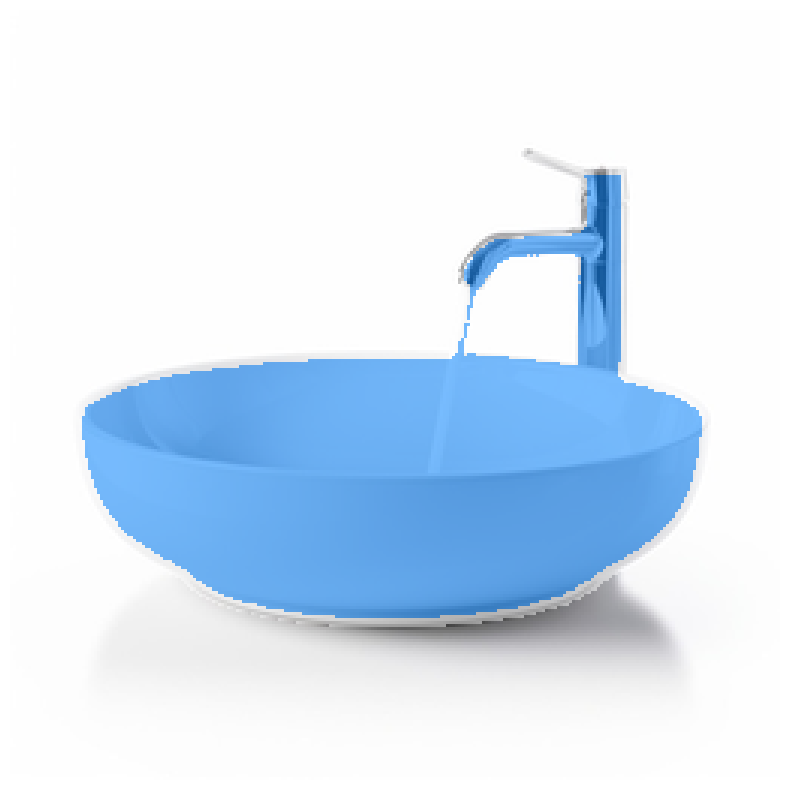

images/white
TARGET COLOR:  orange


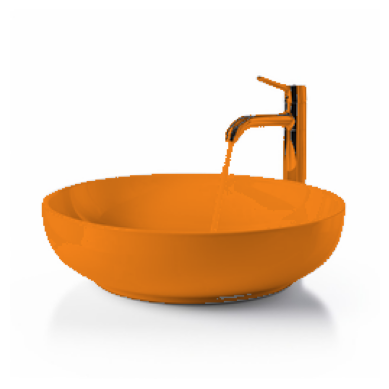

Processing: downloaded_images/white_catamaran_2.jpg


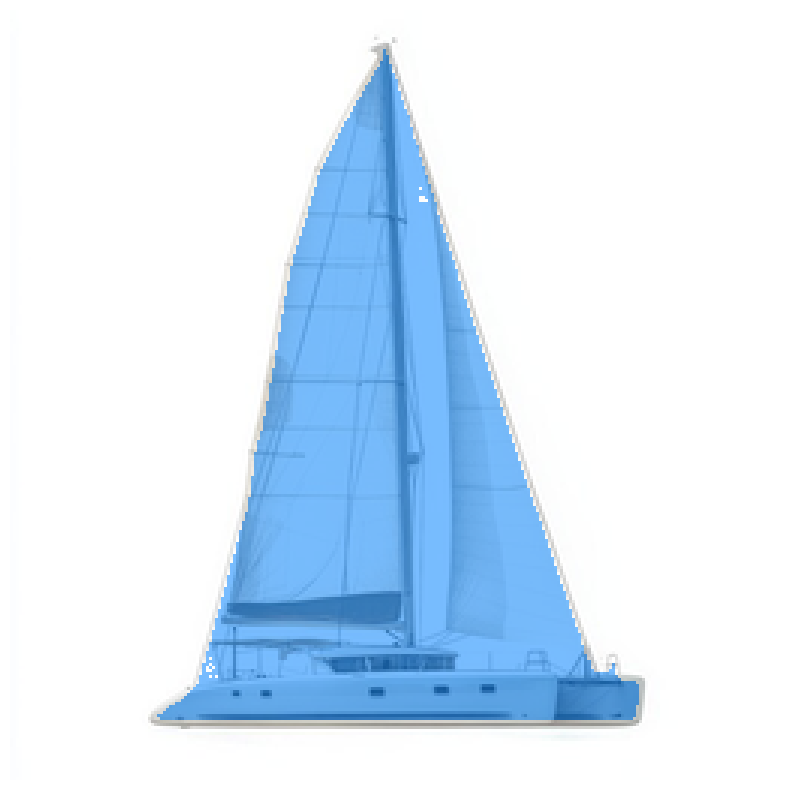

images/white
TARGET COLOR:  brown


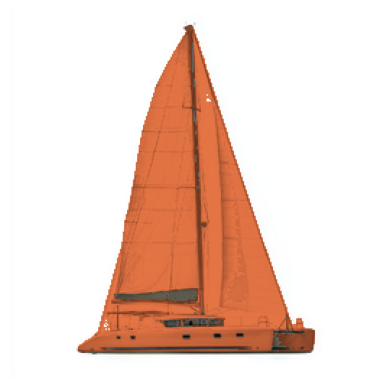

Processing: downloaded_images/white_sewing_machine_1.jpg


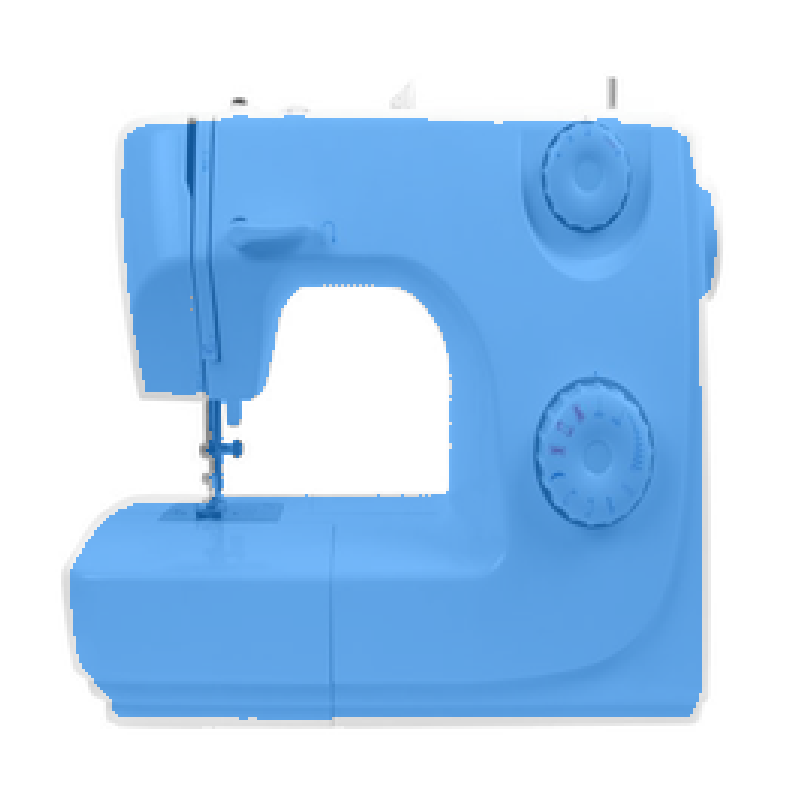

images/white
TARGET COLOR:  yellow


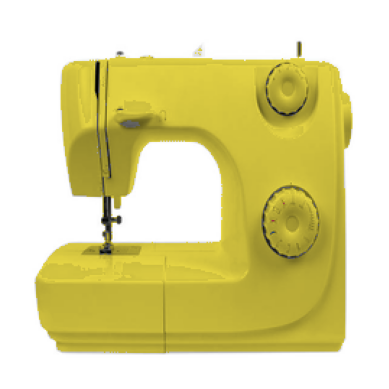

Processing: downloaded_images/white_sulphur-crested_cockatoo_1.jpg


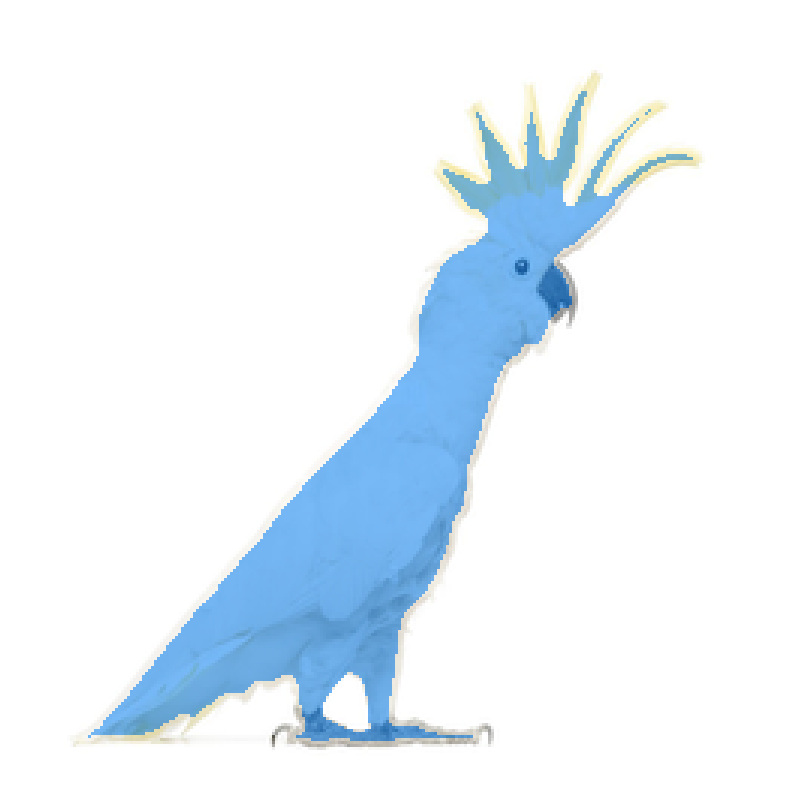

images/white
TARGET COLOR:  green


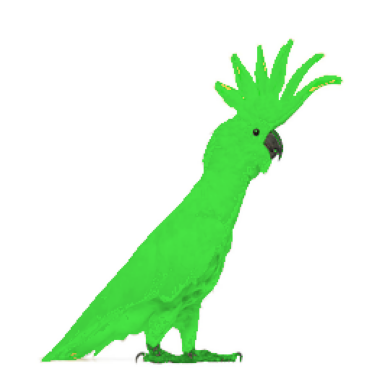

Processing: downloaded_images/white_lamb_2.jpg


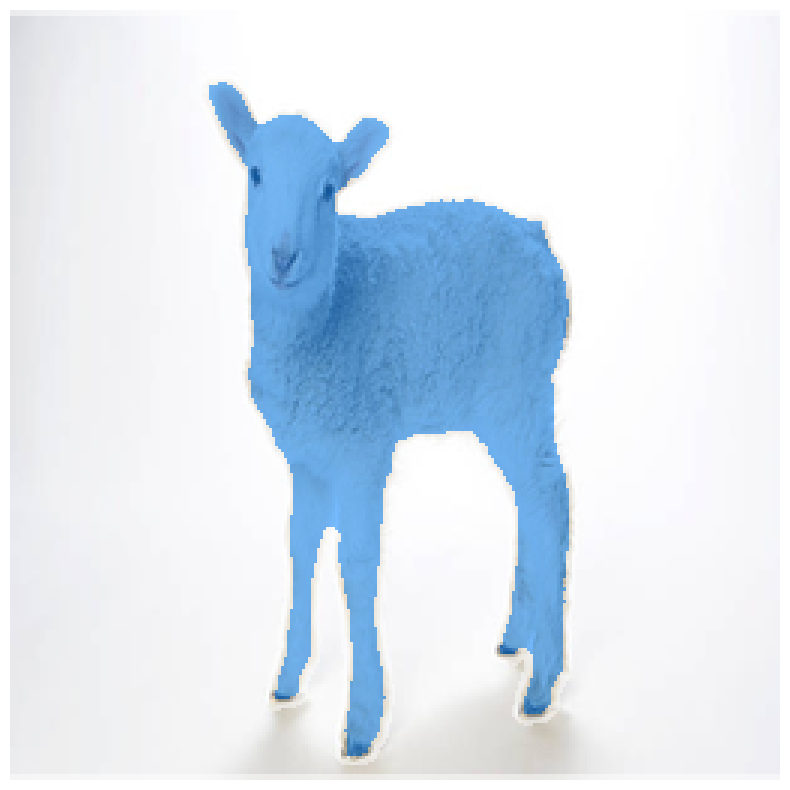

images/white
TARGET COLOR:  green


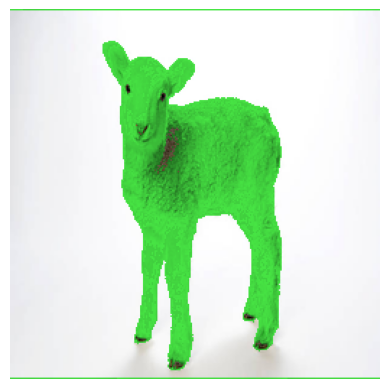

Processing: downloaded_images/white_birch_2.jpg


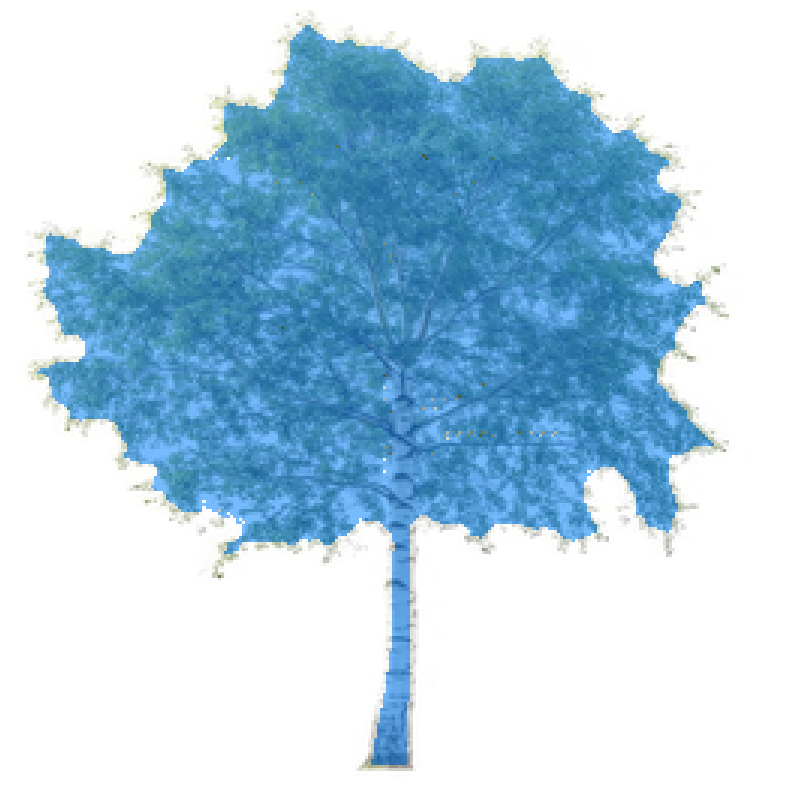

images/white
TARGET COLOR:  pink


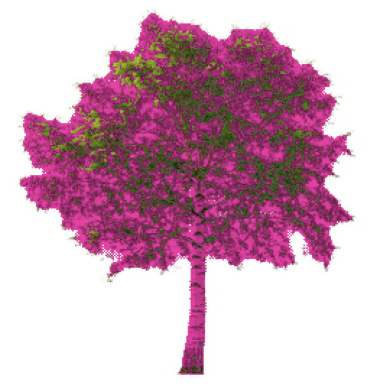

Processing: downloaded_images/white_mug_1.jpg


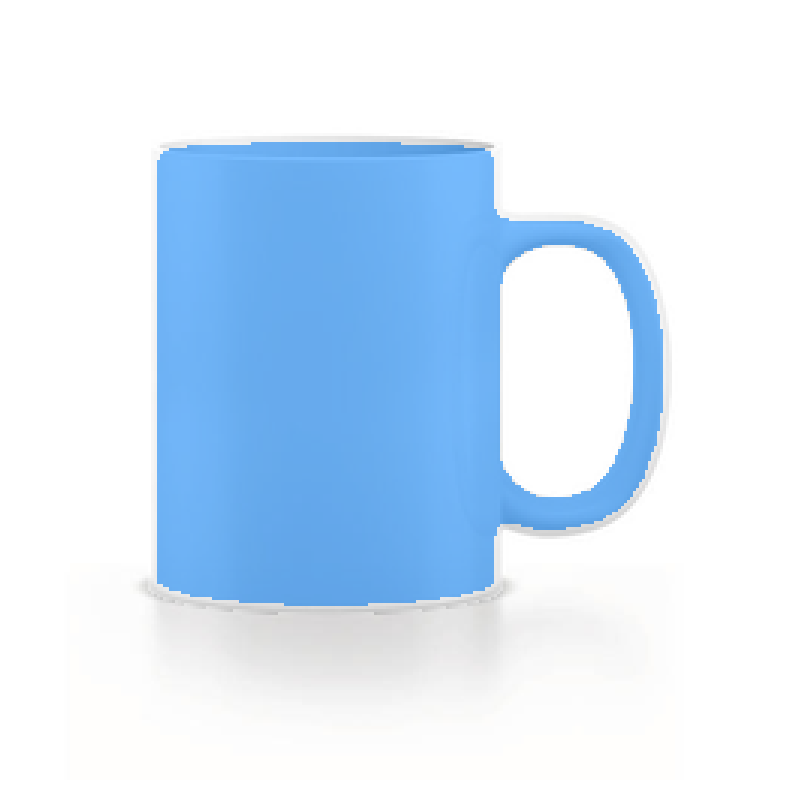

images/white
TARGET COLOR:  pink


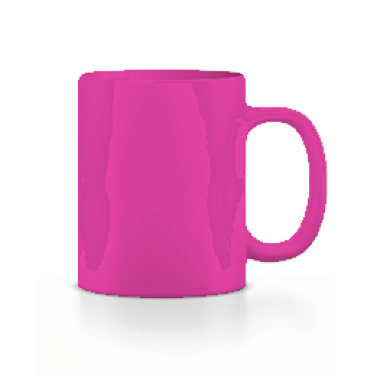

Processing: downloaded_images/white_Arctic_fox_2.jpg


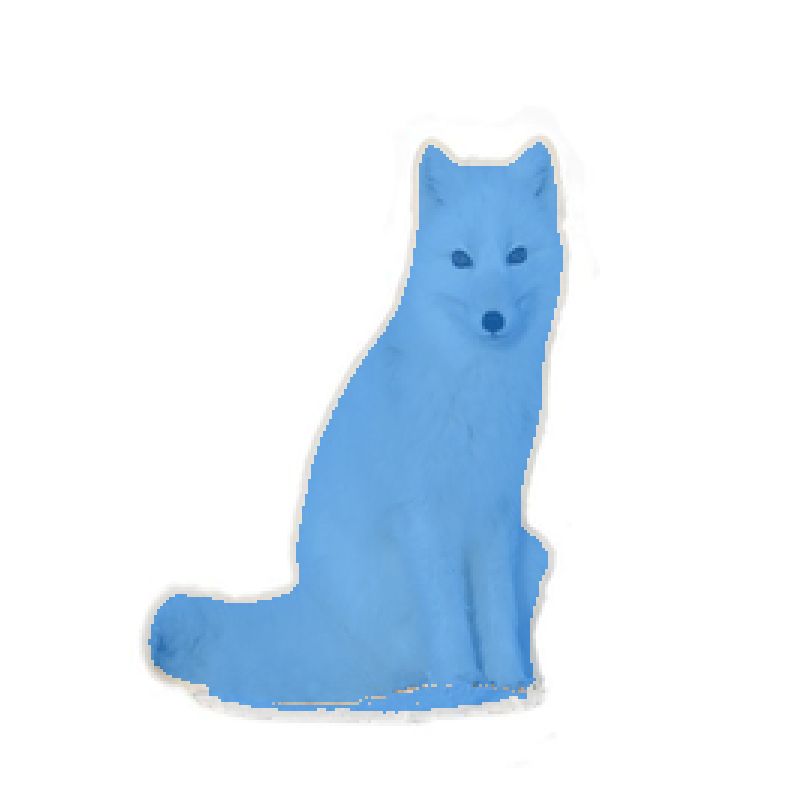

images/white
TARGET COLOR:  orange


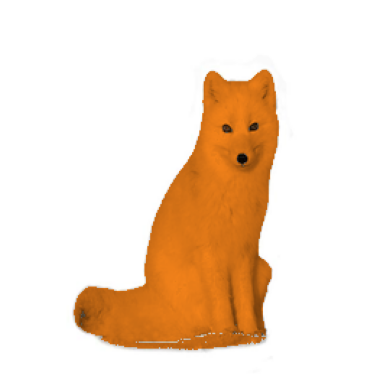

Processing: downloaded_images/white_fridge_1.jpg


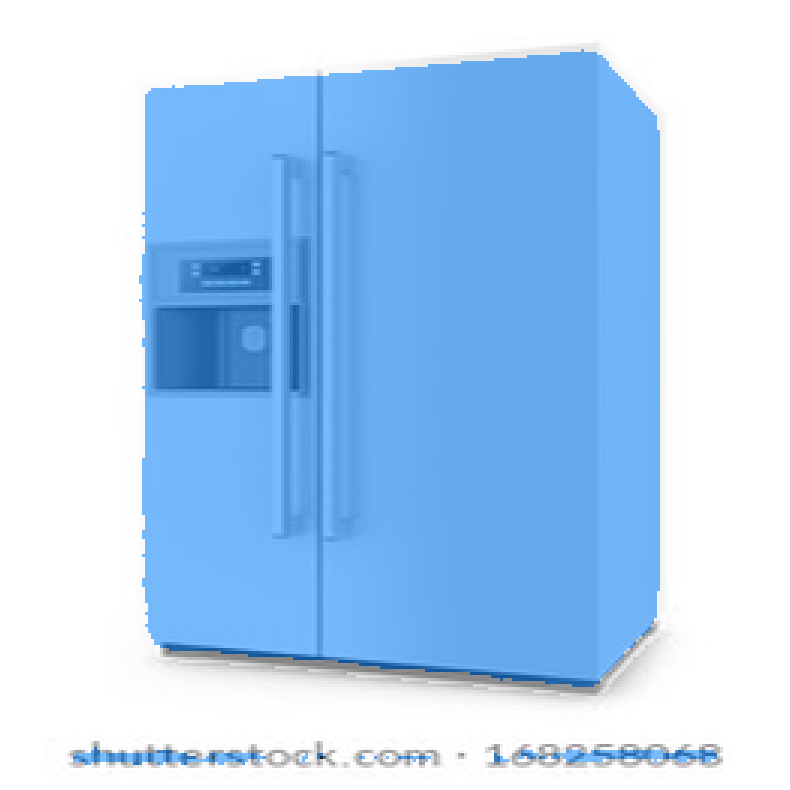

images/white
TARGET COLOR:  yellow


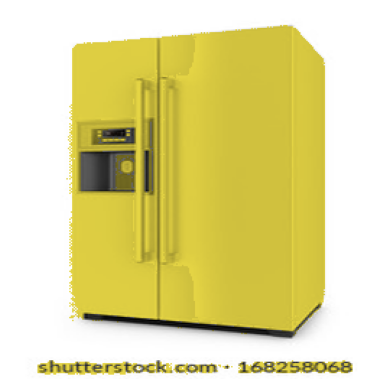

Processing: downloaded_images/white_toilet_1.jpg


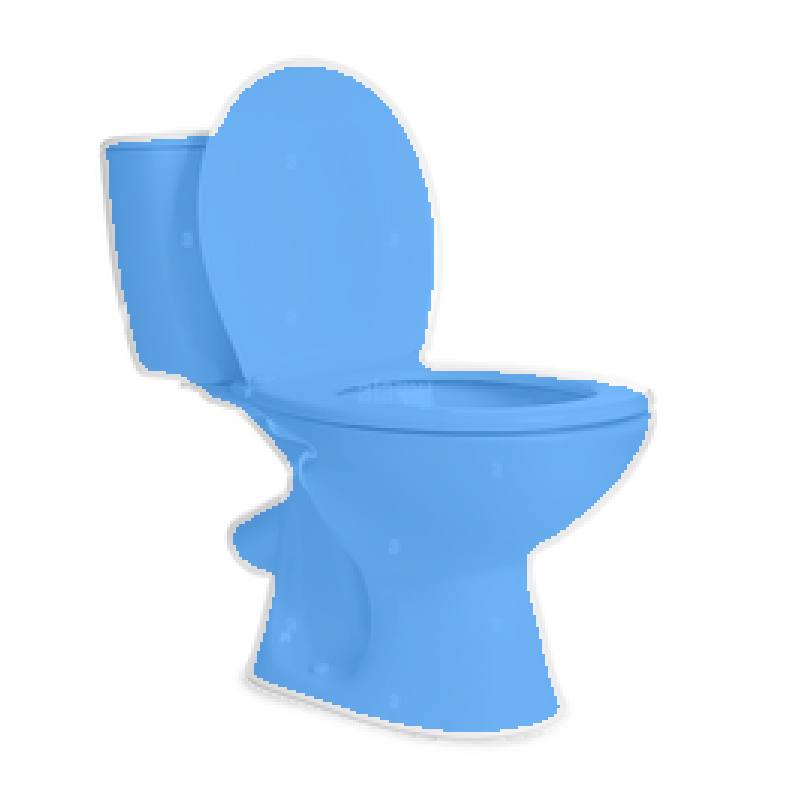

images/white
TARGET COLOR:  brown


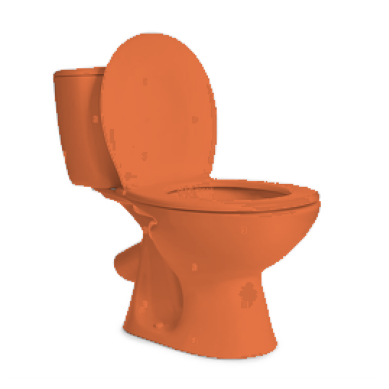

In [16]:
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import cv2

import pickle

# --- Function Definitions ---

def find_bounding_box_with_threshold(image, block_size=11, C=2):
    """
    Compute a bounding box for an image using adaptive thresholding.
    Assumes that the image is in grayscale mode (PIL 'L').
    """
    np_img = np.array(image)
    # Adaptive thresholding: invert so that white objects become dark and easier to find.
    thresh = cv2.adaptiveThreshold(
        np_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, block_size, C
    )

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return (0, 0, image.width - 1, image.height - 1)

    # Combine all contours to get a bounding rectangle that encompasses them
    all_contours = np.vstack(contours)
    x, y, w, h = cv2.boundingRect(all_contours)
    return (x, y, x + w, y + h)

def pad_bbox(bbox, pad, img_width, img_height):
    """Expands the bounding box by a pad value while remaining within image boundaries."""
    x1, y1, x2, y2 = bbox
    x1 = max(x1 - pad, 0)
    y1 = max(y1 - pad, 0)
    x2 = min(x2 + pad, img_width - 1)
    y2 = min(y2 + pad, img_height - 1)
    return (x1, y1, x2, y2)

def white_remap(pixel, mask_value, current_color, target_color):
    color_hue_map = {
        "red":    0.0,         
        "brown":  0.05,
        "pink":   0.9,        
        "orange": 0.08,     
        "yellow": 0.15,
        "gold":   0.1,
        "green":  0.33,              
        "blue":   0.52,      
        "purple": 0.78,     
        "black":  0.0,     
        "grey":   0.0,
        "silver": 0.0,
        "white":  0.0,     
    }
    
    # Only remap when the mask flags the pixel.
    if mask_value == 0:
        return pixel
    
    target_hue = color_hue_map.get(target_color, 0.0)
    r, g, b = pixel
    h, s, v = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)
    
    # We'll remap pixels that are not too saturated and are bright enough.
    if s < 0.6 and v > 0.4:
        new_h = target_hue
        
        # Apply custom saturation boost for orange.
        if target_color == "orange":
            new_h = 0.08
            # Multiply the original saturation by 1.3 with a floor of 0.65.
            new_s = min(max(s * 1.5, 0.89), 1.0)
            new_v = v if v < 0.95 else v * 0.95
        else:
            # For other colors, use the more aggressive boost.
            new_s = min(max(s * 1.4, 0.7), 1.0)
            
            # Keep the brightness to preserve shading details.
            new_v = v if v < 0.9 else v * 0.9
            
        r_new, g_new, b_new = colorsys.hsv_to_rgb(new_h, new_s, new_v)
        return int(r_new * 255), int(g_new * 255), int(b_new * 255)
    
    # If pixel doesn't meet our criteria, leave it unchanged.
    return pixel

# MAIN FUNCTION
all_masks = {}
counterfact_paths = {}
for idx, row in df.sample(50).iterrows():
    if row['correct_answer'] == 'white':
        print("Processing:", row["image_path"])
        img = Image.open(base_path + row["image_path"]).convert("RGB").resize((256, 256), Image.LANCZOS)
        
        # Enhance contrast to help find the object in the image.
        enhancer = ImageEnhance.Contrast(img)
        enhanced_img = enhancer.enhance(2.0)
        enhanced_gray = enhanced_img.convert("L")
        
        # Compute bounding box over the edited image. 
        bbox = find_bounding_box_with_threshold(enhanced_gray, block_size=11, C=2)
        bbox = pad_bbox(bbox, pad=5, img_width=img.width, img_height=img.height)
        
        # IMPORTANT!!! Set the original image without contrast boost for the SAM predictor.
        predictor.set_image(img)
        
        # Run SAM predictor with the computed bounding box.
        masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=np.array(bbox)[None, :],
            multimask_output=False,
        )
        
        # Sort the masks by score (highest first)
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]
    
        # Fix the mask if the segmentation has an inverted mask (if applicable)
        masks = fix_inverse_mask(masks)
        # Show the masks for debugging
        show_masks(img, masks, scores, borders=True)

        # Saving the masks with the new file path as key. 
        color_to_replace = row['image_path'].split('_')[1]
        print(color_to_replace)
        new_path = row['image_path'].replace(color_to_replace, row['incorrect_answer'])
        new_path = new_path.replace('downloaded_images', 'downloaded_images_counterfact')
        counterfact_paths[idx] = new_path
        
        counterfact_paths[idx] = new_path
        
        all_masks[counterfact_paths[idx]] = masks[0]
    
        # re-shape mask 
        mask_squeezed = masks.squeeze() 
        mask_flat = mask_squeezed.flatten() 
        masks = mask_flat.tolist()
    
        # Color re-map using the MASKS. 
        pixels = list(img.getdata())
    
        print("TARGET COLOR: ", row['incorrect_answer']) 
        
        remapped_pixels = [
            white_remap(pixel, mask_value, row['correct_answer'], row['incorrect_answer'].lower())
            for pixel, mask_value in zip(pixels, masks)
        ]
    
        # Create a new image from the remapped pixels
        img_remapped = Image.new('RGB', img.size)
        img_remapped.putdata(remapped_pixels)
        
        plt.imshow(img_remapped)
        plt.axis('off')  # optional: hides axis ticks
        plt.show()
        
        img_remapped.save(new_path)
    
    else:
        continue
        
#UNCOMMENT to save the masks.   
with open("../final_real_images_masks_white.pkl", "wb") as f:
    pickle.dump(all_masks, f)

In [ ]:
# UNCOMMENT when running the full pipeline

# NOW TAKE COUNTERFACT PATHS AND SORT THEN ADD TO DF. d
counterfact_paths = dict(sorted(counterfact_paths.items()))
df["counterfact_paths"] = list(counterfact_paths.values())
df.to_csv("final_images_with_counterfact.csv")